In [1]:

import matplotlib.pyplot as plt
from itertools import permutations, combinations
from random import shuffle
import random
import numpy as np
import statistics
import pandas as pd
import seaborn as SNs
import imageio

no eliminar ------ lectura de datos

In [2]:
def load_tsp_data(file_path):
    coords = []
    section = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if line.startswith("NODE_COORD_SECTION"):
                section = True
                continue

            if line == "EOF":
                break

            if section:
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1]), float(parts[2])
                        coords.append((x, y))
                    except ValueError:
                        print(f"Error al convertir: {parts}")

    return coords

In [3]:
coords = load_tsp_data('ch150.tsp')
coords

[(37.4393516691, 541.2090699418),
 (612.1759508571, 494.3166877396),
 (38.1312338227, 353.1484581781),
 (53.4418081065, 131.484901365),
 (143.0606355347, 631.7200953923),
 (689.9451267256, 468.5354998742),
 (112.7478815786, 529.417757826),
 (141.4875865042, 504.818485571),
 (661.0513901702, 445.9375182115),
 (98.7899036592, 384.5926031158),
 (697.3881696597, 180.3962284275),
 (536.4894189738, 287.2279085051),
 (192.4067320507, 20.439405931),
 (282.7865258765, 229.8001556189),
 (240.8251726391, 281.51414372),
 (246.9281323057, 322.461332116),
 (649.7313216456, 62.3331575282),
 (352.96585626, 666.7873101942),
 (633.392367658, 534.9398453712),
 (488.311799404, 437.4869439948),
 (141.4039286509, 228.4325551488),
 (17.3632612602, 240.2407068508),
 (397.5586451389, 231.3591208928),
 (565.7853781464, 282.3858748974),
 (475.8975387047, 468.5392706317),
 (322.4224566559, 550.3165478233),
 (397.5586634023, 74.7588387765),
 (672.8618339396, 432.882640963),
 (571.2189680147, 530.261699153),
 (104.

In [4]:
len(coords)

150

In [5]:
city_coords = {str(i+1): coord for i, coord in enumerate(coords)}
city_coords

{'1': (37.4393516691, 541.2090699418),
 '2': (612.1759508571, 494.3166877396),
 '3': (38.1312338227, 353.1484581781),
 '4': (53.4418081065, 131.484901365),
 '5': (143.0606355347, 631.7200953923),
 '6': (689.9451267256, 468.5354998742),
 '7': (112.7478815786, 529.417757826),
 '8': (141.4875865042, 504.818485571),
 '9': (661.0513901702, 445.9375182115),
 '10': (98.7899036592, 384.5926031158),
 '11': (697.3881696597, 180.3962284275),
 '12': (536.4894189738, 287.2279085051),
 '13': (192.4067320507, 20.439405931),
 '14': (282.7865258765, 229.8001556189),
 '15': (240.8251726391, 281.51414372),
 '16': (246.9281323057, 322.461332116),
 '17': (649.7313216456, 62.3331575282),
 '18': (352.96585626, 666.7873101942),
 '19': (633.392367658, 534.9398453712),
 '20': (488.311799404, 437.4869439948),
 '21': (141.4039286509, 228.4325551488),
 '22': (17.3632612602, 240.2407068508),
 '23': (397.5586451389, 231.3591208928),
 '24': (565.7853781464, 282.3858748974),
 '25': (475.8975387047, 468.5392706317),
 '

---------------------------------------------------------------------------------- termina lectura de datos

In [6]:
def initial_population(cities_list, n_population=200):
    population = []
    for _ in range(n_population):
        individual = cities_list[:]  # Copia de la lista de ciudades
        random.shuffle(individual)  # Mezclar aleatoriamente
        population.append(individual)
    return population


In [7]:
n_cities = len(city_coords)
distance_matrix = np.zeros((n_cities, n_cities))

for i, (x1, y1) in enumerate(city_coords.values()):
    for j, (x2, y2) in enumerate(city_coords.values()):
        distance_matrix[i, j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def dist_two_cities(city_1, city_2):
    index_1 = int(city_1) - 1  # Convertir de string a índice
    index_2 = int(city_2) - 1
    return distance_matrix[index_1, index_2]

In [8]:
def total_dist_individual(individual):

    """
    Calculating the total distance traveled by individual,
    one individual means one possible solution (1 permutation)
    Input:
    1- Individual list of cities
    Output:
    Total distance traveled
    """

    total_dist = 0
    for i in range(0, len(individual)):
        if(i == len(individual) - 1):
            total_dist += dist_two_cities(individual[i], individual[0])
        else:
            total_dist += dist_two_cities(individual[i], individual[i+1])
    return total_dist

In [9]:
def fitness_prob(population):
    total_dist_all_individuals = np.array([total_dist_individual(ind) for ind in population])

    max_population_cost = np.max(total_dist_all_individuals)
    population_fitness = max_population_cost - total_dist_all_individuals

    population_fitness_sum = np.sum(population_fitness)

    # Si la suma es cero, asigna probabilidades iguales a todos los individuos
    if population_fitness_sum == 0:
        return np.ones(len(population)) / len(population)

    return population_fitness / population_fitness_sum

In [10]:
def roulette_wheel(population, fitness_probs):
    """
    Implement a selection strategy based on proportionate roulette wheel
    Selection.
    Input:
    1- population
    2: fitness probabilities
    Output:
    selected individual
    """
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    bool_prob_array = population_fitness_probs_cumsum < np.random.uniform(0,1,1)
    selected_individual_index = len(bool_prob_array[bool_prob_array == True]) - 1
    return population[selected_individual_index]

In [11]:
def crossover(parent_1, parent_2):
    """
    Implement mating strategy using simple crossover between two parents
    Input:
    1- parent 1
    2- parent 2
    Output:
    1- offspring 1
    2- offspring 2
    """
    n_cities_cut = len(city_coords) - 1
    cut = round(random.uniform(1, n_cities_cut))
    offspring_1 = []
    offspring_2 = []

    offspring_1 = parent_1 [0:cut]
    offspring_1 += [city for city in parent_2 if city not in offspring_1]


    offspring_2 = parent_2 [0:cut]
    offspring_2 += [city for city in parent_1 if city not in offspring_2]


    return offspring_1, offspring_2

In [12]:
def mutation(offspring):
    """
    Implement mutation strategy in a single offspring
    Input:
    1- offspring individual
    Output:
    1- mutated offspring individual
    """
    n_cities_cut = len(city_coords) - 1
    index_1 = round(random.uniform(0,n_cities_cut))
    index_2 = round(random.uniform(0,n_cities_cut))

    temp = offspring [index_1]
    offspring[index_1] = offspring[index_2]
    offspring[index_2] = temp
    return(offspring)

In [13]:
def run_ga(cities_names, n_population, n_generations,
           crossover_per, mutation_per):

    population = initial_population(cities_names, n_population)
    fitness_probs = fitness_prob(population)

    parents_list = []
    for i in range(0, int(crossover_per * n_population)):
        parents_list.append(roulette_wheel(population,
                                           fitness_probs))

    offspring_list = []
    for i in range(0,len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i],
                                             parents_list[i+1])

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_1 = mutation(offspring_1)

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_2 = mutation(offspring_2)


        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_prob(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[0:n_population]
    best_mixed_offsrping = []
    for i in best_fitness_indices:
        best_mixed_offsrping.append(mixed_offspring[i])

    while len(best_mixed_offsrping) < n_population:
      best_mixed_offsrping.append(random.choice(population))


    for i in range(0, n_generations):

        fitness_probs = fitness_prob(best_mixed_offsrping)
        parents_list = []
        for i in range(0, int(crossover_per * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offsrping,
                                               fitness_probs))

        offspring_list = []
        for i in range(0,len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i],
                                                 parents_list[i+1])

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_1 = mutation(offspring_1)

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)


        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[0:int(0.8*n_population)]

        best_mixed_offsrping = []
        for i in best_fitness_indices:
            best_mixed_offsrping.append(mixed_offspring[i])

        old_population_indices = [random.randint(0, (n_population - 1))
                                  for j in range(int(0.2*n_population))]
        for i in old_population_indices:
            best_mixed_offsrping.append(population[i])

        random.shuffle(best_mixed_offsrping)

    return best_mixed_offsrping

In [14]:
cities_names = []
for i in range(len(city_coords)):
    cities_names.append(str(i+1))

cities_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '13

In [15]:
n_population = 700
crossover_per = 0.8
mutation_per = 0.2
n_generations = 8000

In [16]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)


In [17]:
print(f"Tamaño de best_mixed_offsrping: {len(best_mixed_offsrping)}")
print(f"Tamaño esperado: {n_population}")

Tamaño de best_mixed_offsrping: 700
Tamaño esperado: 700


In [18]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))


In [19]:
index_minimum = np.argmin(total_dist_all_individuals)
minimum_distance = min(total_dist_all_individuals)

shortest_path = best_mixed_offsrping[index_minimum]

In [20]:
print(f"El camino más corto es: {shortest_path}")
print(f"La distancia mínima es: {minimum_distance}")

El camino más corto es: ['90', '51', '12', '43', '109', '134', '16', '59', '79', '121', '96', '89', '8', '7', '84', '62', '149', '125', '150', '115', '106', '91', '119', '68', '4', '104', '22', '88', '94', '73', '76', '87', '1', '103', '97', '18', '65', '55', '58', '81', '110', '47', '139', '40', '36', '61', '69', '41', '129', '145', '136', '13', '74', '123', '31', '140', '60', '66', '17', '130', '148', '11', '6', '29', '86', '50', '135', '70', '108', '19', '99', '114', '102', '137', '132', '85', '142', '143', '100', '82', '95', '107', '5', '75', '83', '92', '54', '46', '138', '67', '116', '101', '39', '127', '118', '120', '42', '37', '2', '20', '25', '141', '93', '35', '10', '113', '3', '48', '63', '30', '124', '126', '33', '105', '111', '45', '128', '71', '44', '21', '78', '15', '77', '131', '32', '38', '23', '49', '147', '144', '27', '117', '57', '24', '53', '28', '9', '72', '112', '64', '80', '14', '122', '133', '52', '34', '98', '146', '26', '56']
La distancia mínima es: 11229.456

In [21]:
x_shortest = []
y_shortest = []

for city in shortest_path:
    x_value, y_value = city_coords[city]  # Usamos el diccionario `city_coords`
    x_shortest.append(x_value)
    y_shortest.append(y_value)

x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

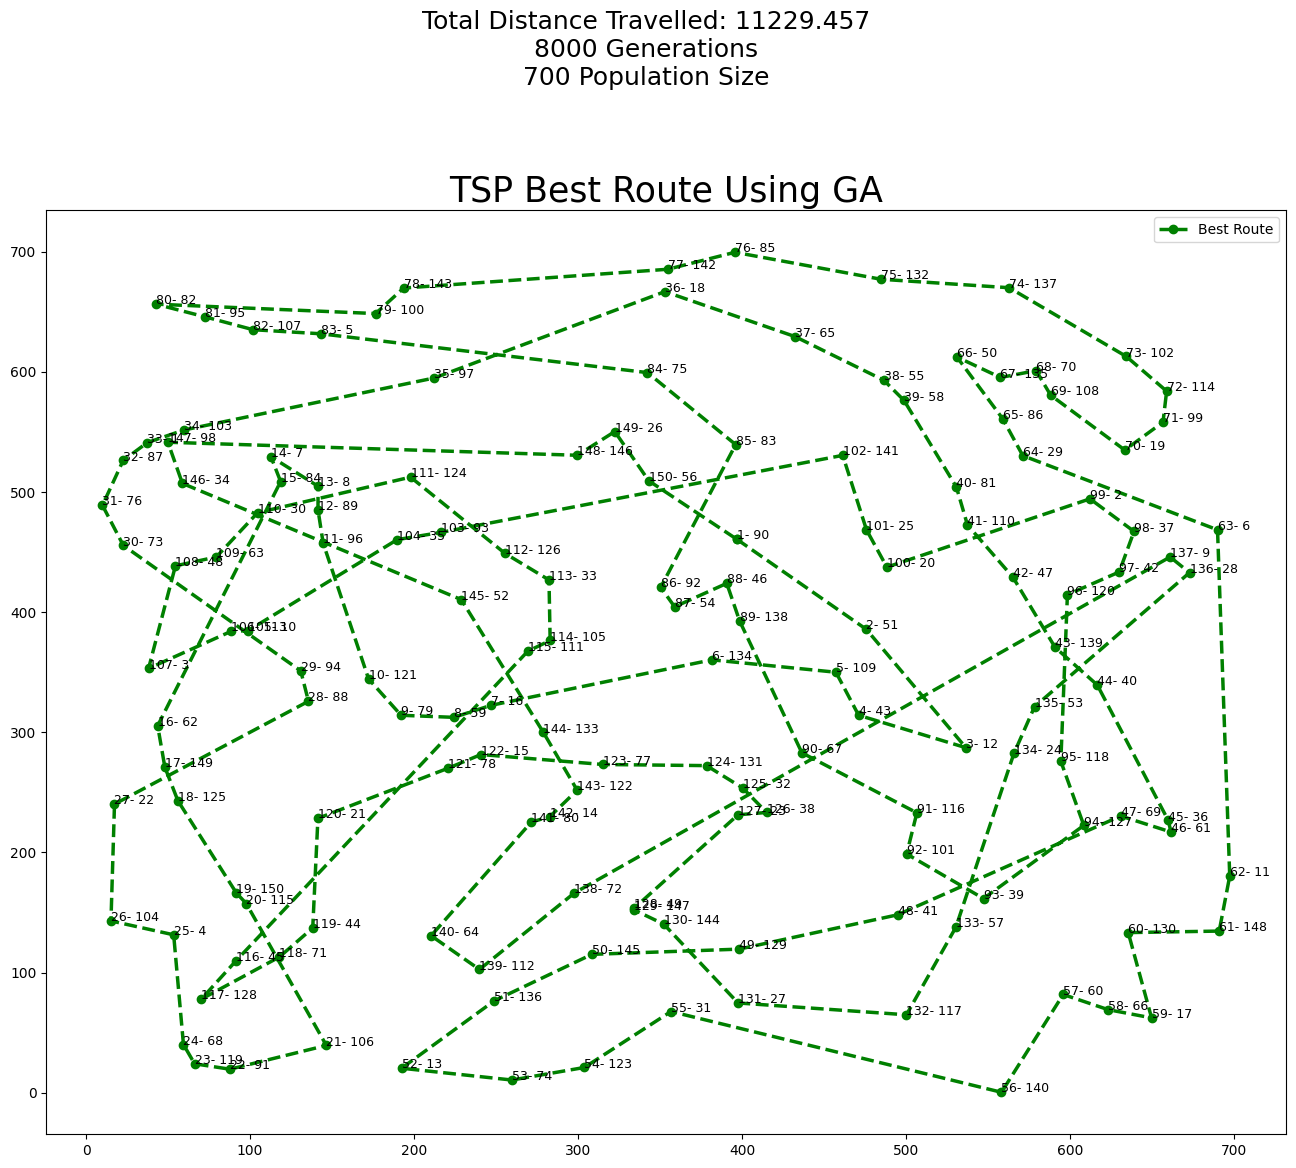

In [22]:
fig, ax = plt.subplots()

ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

plt.title(label="TSP Best Route Using GA", fontsize=25, color="k")

str_params = (
    f'\n{n_generations} Generations\n{n_population} Population Size\n'
)

plt.suptitle(
    "Total Distance Travelled: " + str(round(minimum_distance, 3)) + str_params,
    fontsize=18, y=1.047
)

for i, city in enumerate(shortest_path):
    ax.annotate(f"{i+1}- {city}", (x_shortest[i], y_shortest[i]), fontsize=9)

fig.set_size_inches(16, 12)
plt.show()

In [27]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import random
import os

In [28]:
if not os.path.exists("temp_gif"):
    os.makedirs("temp_gif")

In [29]:
def save_generation_image(shortest_path, generation, minimum_distance):
    """Guardar una imagen del camino más corto encontrado hasta el momento."""
    x_shortest, y_shortest = [], []

    for city in shortest_path:
        x_value, y_value = city_coords[city]
        x_shortest.append(x_value)
        y_shortest.append(y_value)

    x_shortest.append(x_shortest[0])
    y_shortest.append(y_shortest[0])

    fig, ax = plt.subplots()
    ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
    plt.legend()

    plt.title(f"TSP Best Route Using GA - Gen {generation}", fontsize=25)
    plt.suptitle(f"Total Distance: {round(minimum_distance, 3)}", fontsize=18)

    for i, city in enumerate(shortest_path):
        ax.annotate(f"{i+1}-{city}", (x_shortest[i], y_shortest[i]), fontsize=9)

    fig.set_size_inches(16, 12)
    image_path = f"temp_gif/gen_{generation}.png"
    plt.savefig(image_path)
    plt.close(fig)

In [30]:
def run_ga_step(population, n_population, crossover_per, mutation_per):
    """Realiza un paso del algoritmo genético."""
    fitness_probs = fitness_prob(population)
    parents_list = [roulette_wheel(population, fitness_probs) for _ in range(int(crossover_per * n_population))]
    offspring_list = []

    for i in range(0, len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i + 1])
        if random.random() > (1 - mutation_per):
            offspring_1 = mutation(offspring_1)
        if random.random() > (1 - mutation_per):
            offspring_2 = mutation(offspring_2)

        offspring_list.extend([offspring_1, offspring_2])

    mixed_offspring = parents_list + offspring_list
    fitness_probs = fitness_prob(mixed_offspring)
    best_indices = np.argsort(fitness_probs)[::-1][:n_population]

    return [mixed_offspring[i] for i in best_indices]

In [36]:
def run_ga_with_visualization(cities_names, n_population, n_generations, crossover_per, mutation_per):
    """Ejecutar el GA y guardar imágenes cada 1000 generaciones."""
    population = initial_population(cities_names, n_population)
    best_path_per_generation = []

    for generation in range(1, n_generations + 1):
        population = run_ga_step(population, n_population, crossover_per, mutation_per)

        if generation % 400 == 0 or generation == n_generations:
            # Obtener el mejor camino hasta ahora
            fitness_probs = fitness_prob(population)
            index_minimum = np.argmax(fitness_probs)
            shortest_path = population[index_minimum]
            minimum_distance = total_dist_individual(shortest_path)

            # Guardar imagen de la generación actual
            save_generation_image(shortest_path, generation, minimum_distance)


In [33]:
def generate_gif(output_path="tsp_evolution.gif"):
    """Generar el GIF usando las imágenes guardadas."""
    images = []
    for file_name in sorted(os.listdir("temp_gif"), key=lambda x: int(x.split('_')[1].split('.')[0])):
        file_path = os.path.join("temp_gif", file_name)
        images.append(imageio.imread(file_path))

    imageio.mimsave(output_path, images, duration=0.5)  # 0.5 segundos por imagen

    # Eliminar las imágenes temporales
    for file_name in os.listdir("temp_gif"):
        os.remove(os.path.join("temp_gif", file_name))
    os.rmdir("temp_gif")


In [34]:
run_ga_with_visualization(cities_names, n_population, n_generations, crossover_per, mutation_per)
generate_gif()
print("GIF generado y guardado como 'tsp_evolution.gif'")

C:\Users\eunic\AppData\Local\Temp\ipykernel_2272\2333372005.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF generado y guardado como 'tsp_evolution.gif'


### ruta optima

In [23]:
def load_optimal_tour(file_path):
    """Cargar el archivo .tour y devolver la lista de ciudades en orden."""
    cities_tour = []
    section = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if line.startswith("TOUR_SECTION"):
                section = True  # Inicia la sección de la ruta
                continue

            if line == "-1" or line == "EOF":
                break  # Fin de la ruta

            if section:
                cities_tour.append(line)  # Agregar ciudad a la lista

    return cities_tour

In [24]:
optimal_tour = load_optimal_tour('ch150.opt.tour')
optimal_tour

['1',
 '98',
 '103',
 '82',
 '95',
 '107',
 '5',
 '100',
 '143',
 '97',
 '146',
 '26',
 '75',
 '18',
 '142',
 '85',
 '65',
 '132',
 '137',
 '50',
 '55',
 '58',
 '141',
 '83',
 '56',
 '90',
 '46',
 '92',
 '54',
 '138',
 '134',
 '131',
 '32',
 '23',
 '38',
 '67',
 '43',
 '109',
 '51',
 '20',
 '25',
 '110',
 '81',
 '29',
 '86',
 '135',
 '70',
 '108',
 '102',
 '114',
 '99',
 '19',
 '2',
 '37',
 '6',
 '28',
 '9',
 '42',
 '120',
 '47',
 '139',
 '40',
 '53',
 '118',
 '24',
 '12',
 '116',
 '101',
 '41',
 '57',
 '39',
 '127',
 '69',
 '36',
 '61',
 '11',
 '148',
 '130',
 '17',
 '66',
 '60',
 '140',
 '117',
 '129',
 '27',
 '31',
 '123',
 '74',
 '13',
 '106',
 '91',
 '119',
 '68',
 '128',
 '45',
 '71',
 '44',
 '64',
 '112',
 '136',
 '145',
 '144',
 '49',
 '147',
 '72',
 '80',
 '14',
 '122',
 '77',
 '133',
 '15',
 '78',
 '21',
 '150',
 '115',
 '4',
 '104',
 '22',
 '125',
 '149',
 '62',
 '3',
 '113',
 '10',
 '94',
 '88',
 '121',
 '79',
 '59',
 '16',
 '111',
 '105',
 '33',
 '126',
 '52',
 '93',
 '124

In [25]:
x_optimal = []
y_optimal = []

for city in optimal_tour:
    x_value, y_value = city_coords[city]  # Coordenadas desde el diccionario `city_coords`
    x_optimal.append(x_value)
    y_optimal.append(y_value)

# Cerrar el ciclo de la ruta
x_optimal.append(x_optimal[0])
y_optimal.append(y_optimal[0])


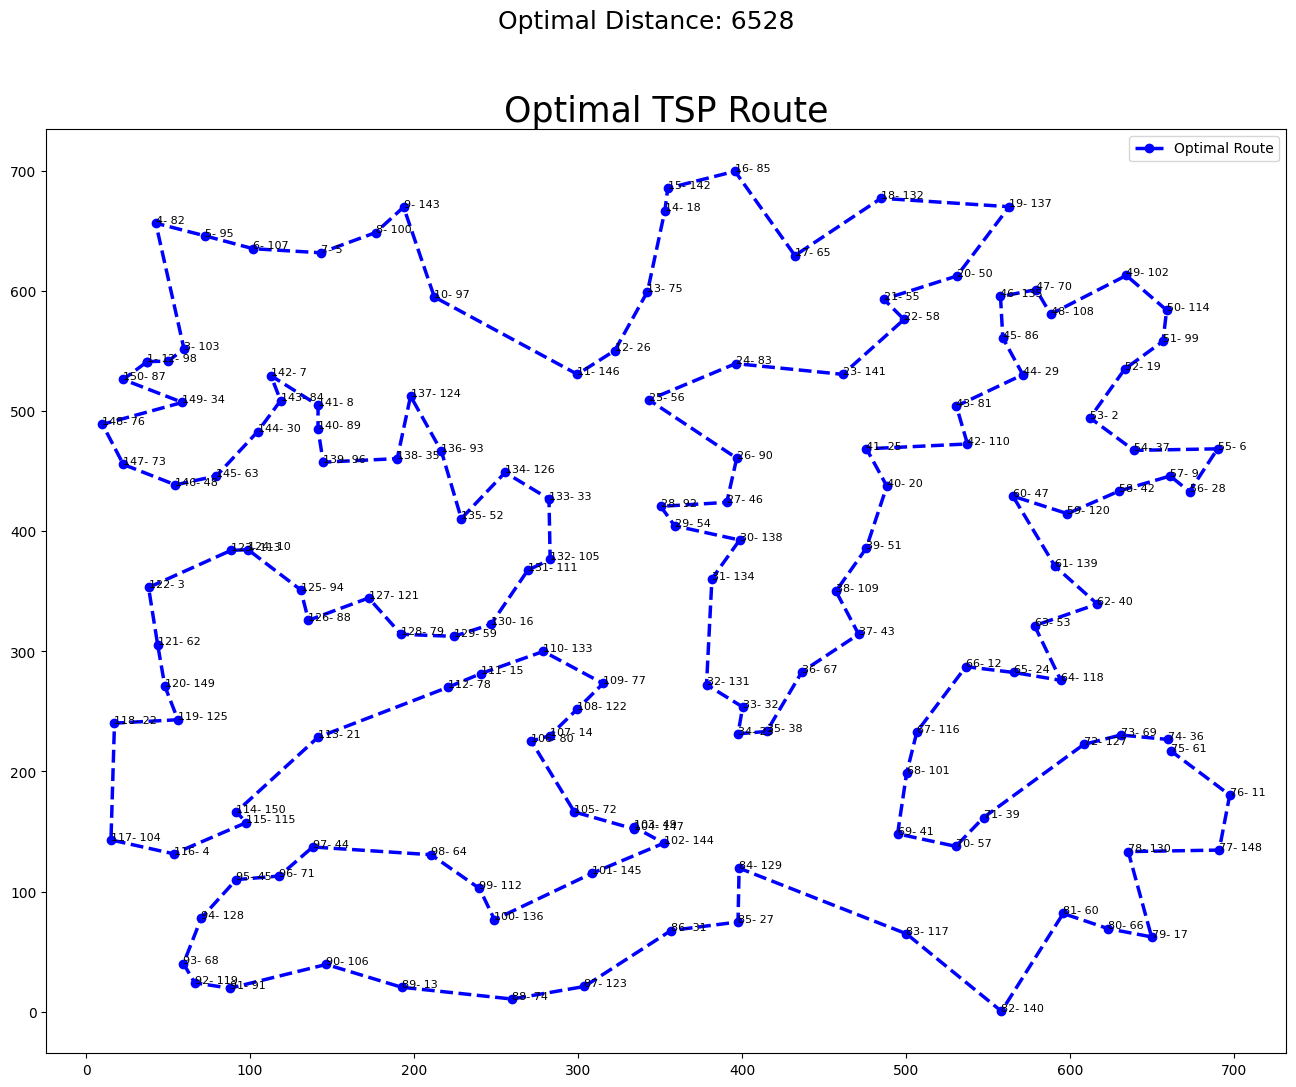

In [26]:
fig, ax = plt.subplots()

# Dibujar la ruta óptima
ax.plot(x_optimal, y_optimal, '--bo', label='Optimal Route', linewidth=2.5)
plt.legend()

# Título y parámetros del gráfico
plt.title(label="Optimal TSP Route", fontsize=25, color="k")
plt.suptitle("Optimal Distance: 6528", fontsize=18)

# Anotar las ciudades en el gráfico
for i, city in enumerate(optimal_tour):
    ax.annotate(f"{i+1}- {city}", (x_optimal[i], y_optimal[i]), fontsize=8)

# Ajustar el tamaño de la figura y mostrar
fig.set_size_inches(16, 12)
plt.show()